In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import zipfile
import json
%matplotlib inline

In [ ]:
df1 = pd.read_csv("./raw_data/cdli_catalogue_1of2.csv",sep=",",encoding="utf-8",error_bad_lines=False)
df2 = pd.read_csv("./raw_data/cdli_catalogue_2of2.csv",sep=",",encoding="utf-8",error_bad_lines=False,header=None,names=df1.columns)

cdli_df = df1.copy()
cdli_df = cdli_df.append(df2)

In [ ]:
cdli_df_sum = cdli_df[cdli_df["language"]=="Sumerian"]
cdli_df_sum = cdli_df_sum[~cdli_df_sum["period"].isna()]
cdli_df_sum = cdli_df_sum[cdli_df_sum["period"].str.contains("Ur III")]
len(cdli_df_sum["id_text"].unique())

In [ ]:
with zipfile.ZipFile('./raw_data/epsd2-admin-u3adm.zip') as myzip:
    corpusnames = [x for x in myzip.namelist() if ("corpusjson" in x) and ("/P") in x]
    
corpus_ids = [int(re.findall(r'\/P(.*).json',x)[0]) for x in corpusnames]
corpus_df = pd.DataFrame(data={"ID":corpus_ids})

dict_id2cdliyear = cdli_df_sum[["id_text","date_of_origin"]].set_index("id_text")["date_of_origin"].to_dict()
corpus_df["DATE"] = corpus_df["ID"].map(dict_id2cdliyear)
corpus_df = corpus_df.dropna()

corpus_df["DATE_CHECK"] = corpus_df["DATE"].apply(lambda x: np.any([y in x for y in ['Shulgi','Ibbi-Suen','Shu-Suen','Amar-Suen']]))
corpus_df=corpus_df[corpus_df["DATE_CHECK"]]

def split_date(the_date):
    the_year,the_month,the_day,comments = np.nan,np.nan,np.nan,np.nan
    splitted_date = the_date.split(".")
    the_year = ".".join(splitted_date[:2])
    if len(splitted_date)>2:
        the_month = splitted_date[2]
    if len(splitted_date)>3:
        splitted_day = splitted_date[3].split(" ")
        the_day = splitted_day[0]
        if len(splitted_day)>1:
            comments = "".join(splitted_day[1:])
    return the_year,the_month,the_day,comments

corpus_df["YEAR"] = corpus_df["DATE"].apply(lambda x: split_date(x)[0])
corpus_df["MONTH"]= corpus_df["DATE"].apply(lambda x: split_date(x)[1])
corpus_df["DAY"]= corpus_df["DATE"].apply(lambda x: split_date(x)[2])
corpus_df["DATE_COMMENTS"]= corpus_df["DATE"].apply(lambda x: split_date(x)[3])

data_y_df = pd.read_csv("./raw_data/year_data.csv",sep=";")
data_y_df["K"] = data_y_df["K"].map({'Shulgi':'Shulgi',
                                          'Unknown':'Unknown',
                                          'Ibb-Sin':'Ibbi-Suen',
                                          'Szu-Sin':'Shu-Suen',
                                          'Amar-Sin':'Amar-Suen',
                                          'Ur-Nammu':'Ur-Namma'})
data_y_df["K.Y_NUM"] = data_y_df["K"]+"."+data_y_df["Y_NUM"].apply(lambda x:"{:02d}".format(x))
dict_cdliyear2ybc = data_y_df[["K.Y_NUM","Y_BC"]].set_index("K.Y_NUM")["Y_BC"].to_dict()
dict_ybc2cdliyear = dict([(v,k) for k,v in dict_cdliyear2ybc.items()])

corpus_df["YEAR_BC"] = corpus_df["YEAR"].map(dict_cdliyear2ybc)
corpus_df = corpus_df[~pd.isna(corpus_df["YEAR_BC"])].drop("DATE_CHECK",axis=1)

In [ ]:
corpus_df.head()

In [22]:
def get_tablet_rawjson(tablet_id):
    fname="epsd2/admin/u3adm/corpusjson/P{}.json".format(tablet_id)
    with zipfile.ZipFile('./raw_data/epsd2-admin-u3adm.zip') as myzip:
        with myzip.open(fname,"r") as f:
            text=f.read().decode('utf-8')
            json_data = json.loads(text)
    return json_data

def parse_tablet_json(data):
    for x in data["cdl"]:
        node_value = x.get("node")
        if node_value=="c":
            for chunk in parse_tablet_json(x):
                yield chunk
        else:
            if node_value=="d":
                if x.get("type")=="line-start":
                    yield ("D","\n:")
                else:
                    yield ("D","\n@"+x.get("type"))
            elif node_value=="l":
                text_fragment = x.get("frag")
                text_lem = x.get("inst")
                for symbol in [u"⸢",u"⸣","[","]","<",">"]:
                    text_fragment = text_fragment.replace(symbol,"")
                yield ("L",text_fragment,text_lem)
                
def parse_corpus(id_list):
    with zipfile.ZipFile('./raw_data/epsd2-admin-u3adm.zip') as myzip:
        data_dict = {}
        for tablet_id in id_list:    
            try:
                fname="epsd2/admin/u3adm/corpusjson/P{}.json".format(tablet_id)
                with myzip.open(fname,"r") as f:
                    text=f.read().decode('utf-8')
                    json_data = json.loads(text)
                parsed_data = list(parse_tablet_json(json_data))
                data_dict[tablet_id]={"raw":" ".join([x[1] for x in parsed_data]),
                                      "splitted":[(x[1],x[2]) for x in parsed_data if x[0]=="L"]}
                
                data_dict[tablet_id]["raw"] = json_data["textid"]+"\n"+data_dict[tablet_id]["raw"]
            except:
                print("Error on id: ",tablet_id)
                data_dict[tablet_id]={"raw":"",
                                      "splitted":[]}
    return data_dict

In [23]:
import time

t0=time.time()
data_dict = parse_corpus(list(corpus_df["ID"].values))
print("Corpus parsed in ",time.time()-t0)

Error on id:  124601
Corpus parsed in  148.4456651210785


In [24]:
corpus_df["GIRI3"] = corpus_df["ID"].apply(lambda x: len(re.findall(r'giri₃ ',data_dict[x]["raw"],re.MULTILINE)))
corpus_df["SUBATI"] = corpus_df["ID"].apply(lambda x: len(re.findall(r'šu#?(?:-|\ )ba#?(?:-|-an#?-)ti#?(?:-a|-eš)?',data_dict[x]["raw"],re.MULTILINE)))
corpus_df["KI"] = corpus_df["ID"].apply(lambda x:  len([x[1] for x in data_dict[x]["splitted"] if "ki[place]"==x[1]]))
corpus_df["I3-DAB5"] = corpus_df["ID"].apply(lambda x: len(re.findall(r'i₃-dab₅',data_dict[x]["raw"],re.MULTILINE)))

Total number of entries: 53338
Number of entries with GIRI3 information >0: 9183
Number of entries with KI information >0: 31394
Number of entries with SUBATI information >0: 12155
Number of entries with I3-DAB5 information >0: 7323

Distribution of entries with year:


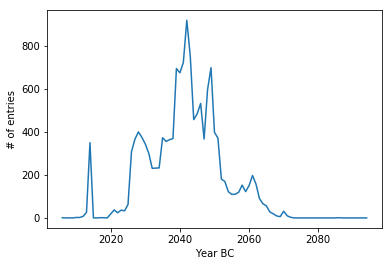

In [31]:
print("Total number of entries:",len(corpus_df))
print("Number of entries with GIRI3 information >0:",len(corpus_df[corpus_df["GIRI3"]>0]))
print("Number of entries with KI information >0:",len(corpus_df[corpus_df["KI"]>0]))
print("Number of entries with SUBATI information >0:",len(corpus_df[corpus_df["SUBATI"]>0]))
print("Number of entries with I3-DAB5 information >0:",len(corpus_df[corpus_df["I3-DAB5"]>0]))

print("\nDistribution of entries with year:")
corpus_df[the_filter]["YEAR_BC"].value_counts().sort_index().plot()
plt.xlabel("Year BC")
plt.ylabel("# of entries")
plt.show()

Filtering on single recipient / single sender transactions....
Number of filtered entries: 14449

Distribution of filtered entries with year:


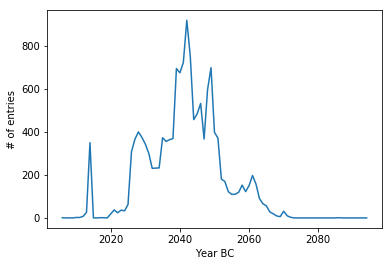

In [32]:
print("Filtering on single recipient / single sender transactions....")
the_filter = (corpus_df["SUBATI"]==1) & (corpus_df["KI"]==1)
the_filter |= (corpus_df["I3-DAB5"]==1) & (corpus_df["KI"]==1)
transac_df = corpus_df[the_filter].copy()

print("Number of filtered entries:",len(transac_df))
print("\nDistribution of filtered entries with year:")
transac_df["YEAR_BC"].value_counts().sort_index().plot()
plt.xlabel("Year BC")
plt.ylabel("# of entries")
plt.show()

In [33]:
## Naive parsers for obtaining names

def get_giri3_information(splitted_text):
    info=""
    for i,elem in enumerate(splitted_text):
        if elem[1]=="ŋiri[foot]":
            try:
                if (splitted_text[i+1][1] in ["PN","X"]):
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
            except:
                pass
    return info

def get_subati_information(splitted_text):
    info=""
    for i,elem in enumerate(splitted_text):
        if len(re.findall(r'ba#?(?:-|-an#?-)ti#?',elem[0])) and len(re.findall(r'šu#?',splitted_text[i-1][0])):
            if (splitted_text[i-2][1] in ["PN","X"]):
                info = splitted_text[i-2][0]
    return info

def get_i3dab5_information(splitted_text):
    info=""
    for i,elem in enumerate(splitted_text):
        if elem[1]=="dab[seize]":
            if (splitted_text[i-1][1] in ["PN","X"]):
                info = splitted_text[i-1][0]      
    return info

def get_ki_information(splitted_text):
    info=""
    for i,elem in enumerate(splitted_text):
        if elem[1]=="ki[place]":
            try:
                if (splitted_text[i+1][1] in ["PN","X"]) and not ("ba-zi" in splitted_text[i+1][0]):
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("ensi₂" in splitted_text[i+1][0]):
                    ## 'ensi₂' indicates a ruler
                    if ("-ta" in splitted_text[i+1][0]): ## if "ensi₂-(XX)-ta" nothing else follows, so the determination is complete
                        info = "ensi₂"
                    else: ## In the other case, a GN follows (as in 'ruler of ...') so we add it
                        info = "ensi₂ "+re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+2][0])
                        
                if ("sanga" in splitted_text[i+1][0]):
                    ## 'sanga' indicates the administrator of a temple, and is followed by the name of the deity
                    info = "sanga "+re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+2][0])
                    
                if ("u"==splitted_text[i+1][1]):
                    ## 'u' indicates unknown, usually badly corrupted, but we'll also take it
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                if ("šeš" in splitted_text[i+1][1]):
                    ## Not exactly sure, but in all cases, this corresponds to 'šeš-a-ni-ta' so we'll consider it as a PN
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("kaš" in splitted_text[i+1][1]):
                    ## Not exactly sure, but in all cases, this corresponds to 'kaš-ta' so we'll consider it as a PN
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("sag[good]" in splitted_text[i+1][1]):
                    ## Not exactly sure, but in all cases, this corresponds to 'ba-sa₆-ta' or variants, so we'll consider it 
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("DN" in splitted_text[i+1][1]):
                    ## DN = Deity names
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                ### TODO: šabra[administrator]
                    
                if ("nammah" in splitted_text[i+1][1]):
                    ## Not exactly sure, but in all cases, this corresponds to 'nam-mah-ta' or variants, so we'll consider it 
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("lu[person]" in splitted_text[i+1][1]):
                    if ("-ta" in splitted_text[i+1][0]): ## if "lu₂-(XX)-ta" nothing else follows, so the determination is complete
                        info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    else: 
                        info = "lu₂ "+re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+2][0])
                        
                if ("diŋir[deity]" in splitted_text[i+1][1]):
                    ## Not exactly sure, but in all cases, this corresponds to 'dingir-ra-ta' or variants, so we'll consider it 
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("kaguruk[supervisor]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'ka-guru₇-ta' or variants, so we'll consider it 
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("mada[land]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'ma-ni-ta' or variants, so we'll consider it 
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("damgar[merchant]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'dam-gar₃-ne-ta' or variants, so we'll consider it 
                    ### TODO: is this a PN, or a function ?
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("lukala[official]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'lu₂-kal-la' or variants, so we'll consider it
                    ### It's a PN: look at tablet P143404, where the lemmatization indicates 'lu₂-kal-la' as a PN
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("ugula[overseer]" in splitted_text[i+1][1]):    
                    ## This is a function name, we will parse all following words until we find "-ta" in it
                    c=2
                    info = refsplitted_textined[i+1][0]+" "
                    while(not "-ta" in splitted_text[i+c][0]):
                        info = splitted_text[i+c][0]+" "
                        c=c+1
                    info = info+" "+re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+c][0])
                    
                if ("niŋurum[property]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'nig₂-u₂-rum' or variants, so we'll consider it
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                ### TODO: nukirik[gardener]
                    
                if ("na[man]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this seems to corresponds to PN
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("unud[cowherd]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'unu₃-e-ne' or variants, so we'll consider it
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
                    
                if ("udul[herdsman]" in splitted_text[i+1][1]):    
                    ## Not exactly sure, but in all cases, this corresponds to 'u₂-du-lu' or variants, so we'll consider it
                    info = re.sub(r'-\[?ta(?:#|\])?$','',splitted_text[i+1][0])
            except:
                pass
            
    return info

In [34]:
transac_df["GIRI3_NAME"] = corpus_df["ID"].apply(lambda x: get_giri3_information(data_dict[x]["splitted"]))
transac_df["SUBATI_NAME"] = corpus_df["ID"].apply(lambda x: get_subati_information(data_dict[x]["splitted"]))
transac_df["KI_NAME"] = corpus_df["ID"].apply(lambda x: get_ki_information(data_dict[x]["splitted"]))
transac_df["I3-DAB5_NAME"] = corpus_df["ID"].apply(lambda x: get_i3dab5_information(data_dict[x]["splitted"]))
transac_df.head()

,ID,DATE,YEAR,MONTH,DAY,DATE_COMMENTS,YEAR_BC,GIRI3,SUBATI,KI,I3-DAB5,GIRI3_NAME,SUBATI_NAME,KI_NAME,I3-DAB5_NAME
2,121532,Ibbi-Suen.02.06.00 (Reichskalender),Ibbi-Suen.02,06,00,(Reichskalender),2027.0,0,1,1,0,,kur-ša-num₂,er₃-re-eb,
8,405489,Amar-Suen.05.11.00,Amar-Suen.05,11,00,NaN,2042.0,0,1,1,0,,{d}šul-gi-iri-mu,{d}šul-gi-a-a-mu,
14,132960,Amar-Suen.07.00.00,Amar-Suen.07,00,00,NaN,2040.0,0,1,1,0,,ur-sa₆-ga-mu,ur-nigar{gar}ta,
17,124307,Amar-Suen.09.12d.10 (intercalated),Amar-Suen.09,12d,10,(intercalated),2038.0,0,0,1,1,,,zu-ba-ga,a-a-kal-la
26,128809,Amar-Suen.02.04.11,Amar-Suen.02,04,11,NaN,2045.0,0,0,1,1,,,ab-ba-sa₆-ga,na-lu₅


In [ ]:
## EXPORT FOR THE D3 VISUALIZATION

json_data = {}
json_data["links"] = []
for i in range(len(transac_df)):
    ki = transac_df.iloc[i]["KI_NAME"]
    subati = transac_df.iloc[i]["SUBATI_NAME"]
    idab = transac_df.iloc[i]["I3-DAB5_NAME"]
    if not ki=="" and (not subati=="" or not idab==""): 
        cdli_id = transac_df.iloc[i]["ID"]
        raw = data_dict[cdli_id]["raw"]
        year = transac_df.iloc[i]["YEAR_BC"]
        if subati=="" and not ki==idab:
            json_data["links"].append({"source":ki,"target":idab,"value":1,"raw":raw,"cdli":int(cdli_id),"year":int(year)})
        elif not ki==subati:
            json_data["links"].append({"source":ki,"target":subati,"value":1,"raw":raw,"cdli":int(cdli_id),"year":int(year)})
            
json_data["Y_2_SUMY"] = dict_ybc2cdliyear

import json
with open('./ur3-viz_data/all.json', 'w') as outfile:
    json.dump(json_data, outfile)